<a href="https://colab.research.google.com/github/erlonL/series-temporais/blob/main/decomposition_initial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import pandas as pd
import numpy as np
import pickle
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from IPython.display import clear_output
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

# Filtra todos os avisos do LightGBM
warnings.filterwarnings("ignore", category=UserWarning, message=".*lightgbm.*")

# Tratamento Inicial do DataFrame

In [45]:
with open('database/df.pkl', 'rb') as f:
    df = pickle.load(f)

df.head()

,item_nbr,year,month,onpromotion,unit_sales,year_month,family,class,perishable,oil_price
0,103520,2013,1,True,201.00,2013-01,GROCERY I,1028,False,94.76
1,103520,2013,2,True,179.00,2013-02,GROCERY I,1028,False,95.31
2,103520,2013,3,True,296.00,2013-03,GROCERY I,1028,False,92.94
3,103520,2013,4,True,212.00,2013-04,GROCERY I,1028,False,92.02
4,103520,2013,5,True,172.00,2013-05,GROCERY I,1028,False,94.51


In [46]:
# essa célula remove os item_nbr que não possuem o máximo de meses possíveis
all_y_months = df['year_month'].unique()

for item_nbr in df['item_nbr'].unique():
    if len(df[df['item_nbr'] == item_nbr]['year_month'].unique()) != len(all_y_months):
        df = df[df['item_nbr'] != item_nbr]

len(df['item_nbr'].unique())

1025

In [47]:
df = df[df['unit_sales'] >= 0]

In [48]:
df.rename(columns={'year_month': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])

#df.set_index('date', inplace=True)

In [49]:
# drop last row (2017-08) because it's incomplete // noise
df = df[df['date'] != '2017-08-01']

# Análise Exploratória

In [50]:
def plot_series(original, trend, seasonal, resid, title=None):
    fig, ax = plt.subplots(4, 1, figsize=(15, 10), layout='constrained')
    original.plot(ax=ax[0])
    ax[0].set_title('Original')
    trend.plot(ax=ax[1])
    ax[1].set_title('Trend')
    seasonal.plot(ax=ax[2])
    ax[2].set_title('Seasonal')
    resid.plot(ax=ax[3])
    ax[3].set_title('Residual')
    if title:
        plt.suptitle(title, fontsize=20)

    plt.show()

In [51]:
def decompose_series(series, period=12, plot=False, title=None):
    decomposition = seasonal_decompose(series, period=period)
    if plot:
        if title is not None:
            plot_series(series, decomposition.trend, decomposition.seasonal, decomposition.resid, title=title)
        else:
            plot_series(series, decomposition.trend, decomposition.seasonal, decomposition.resid)
    return decomposition

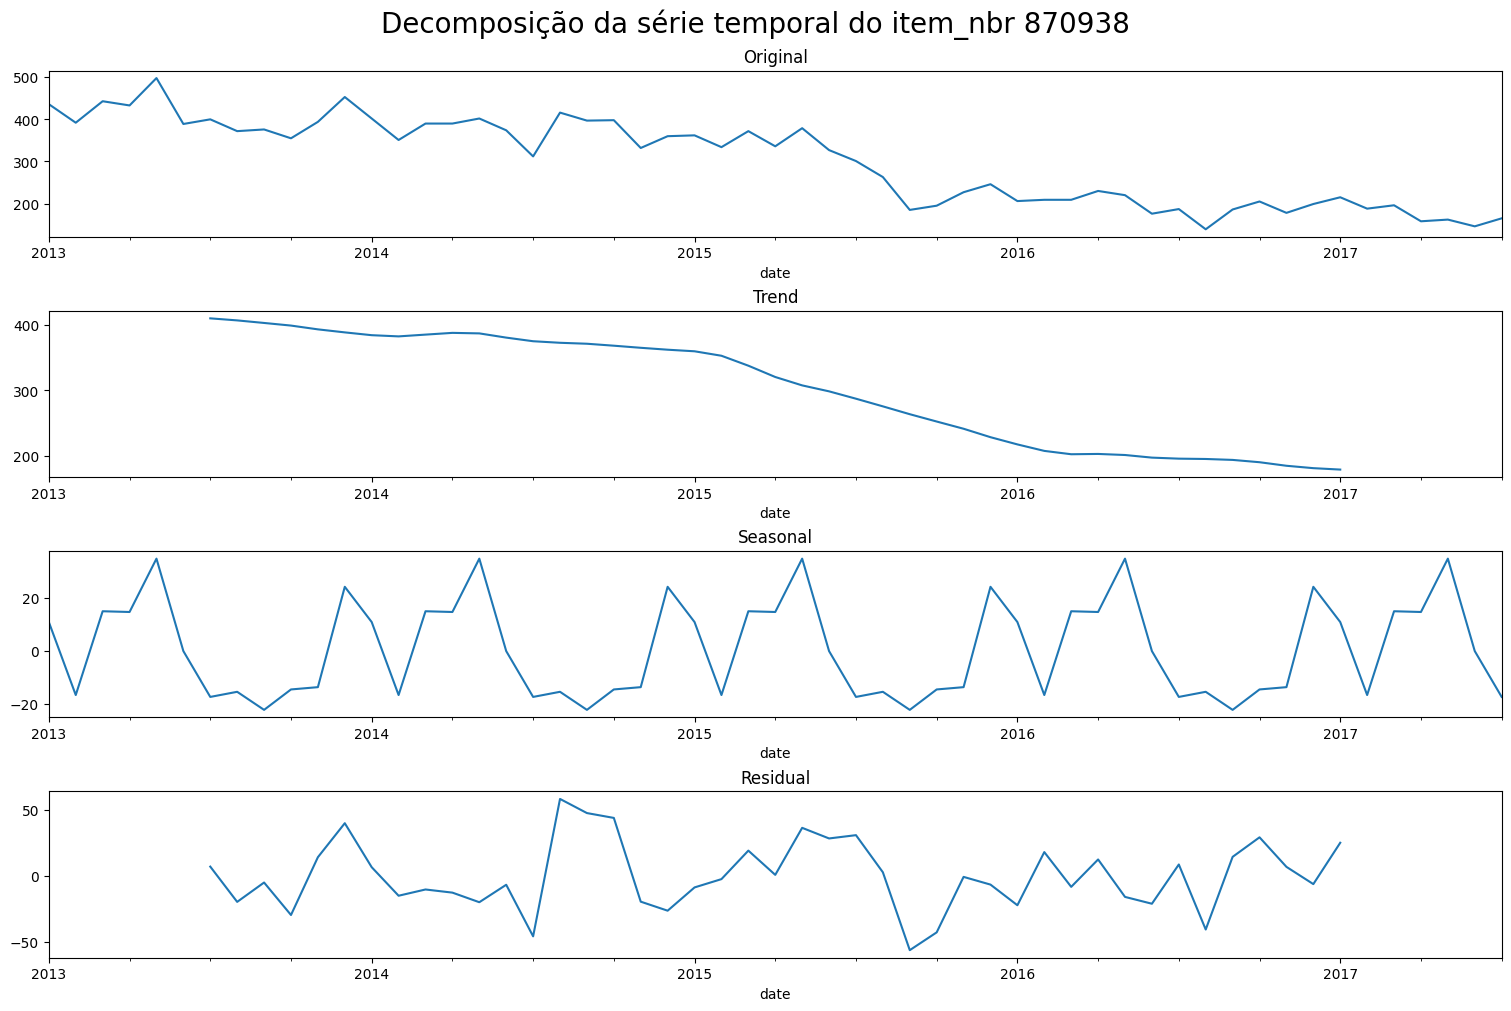

In [52]:
# decompor a série temporal em 3 componentes: tendência, sazonalidade e resíduosfrom statsmodels.tsa.seasonal import seasonal_decompose

item_nbr = 870938 # produto classe: DAIRY, perishable: True
df_item = df[df['item_nbr'] == item_nbr]
df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()
df_item.set_index('date', inplace=True)
decompose_series(df_item['unit_sales'], period=12, plot=True, title='Decomposição da série temporal do item_nbr 870938')

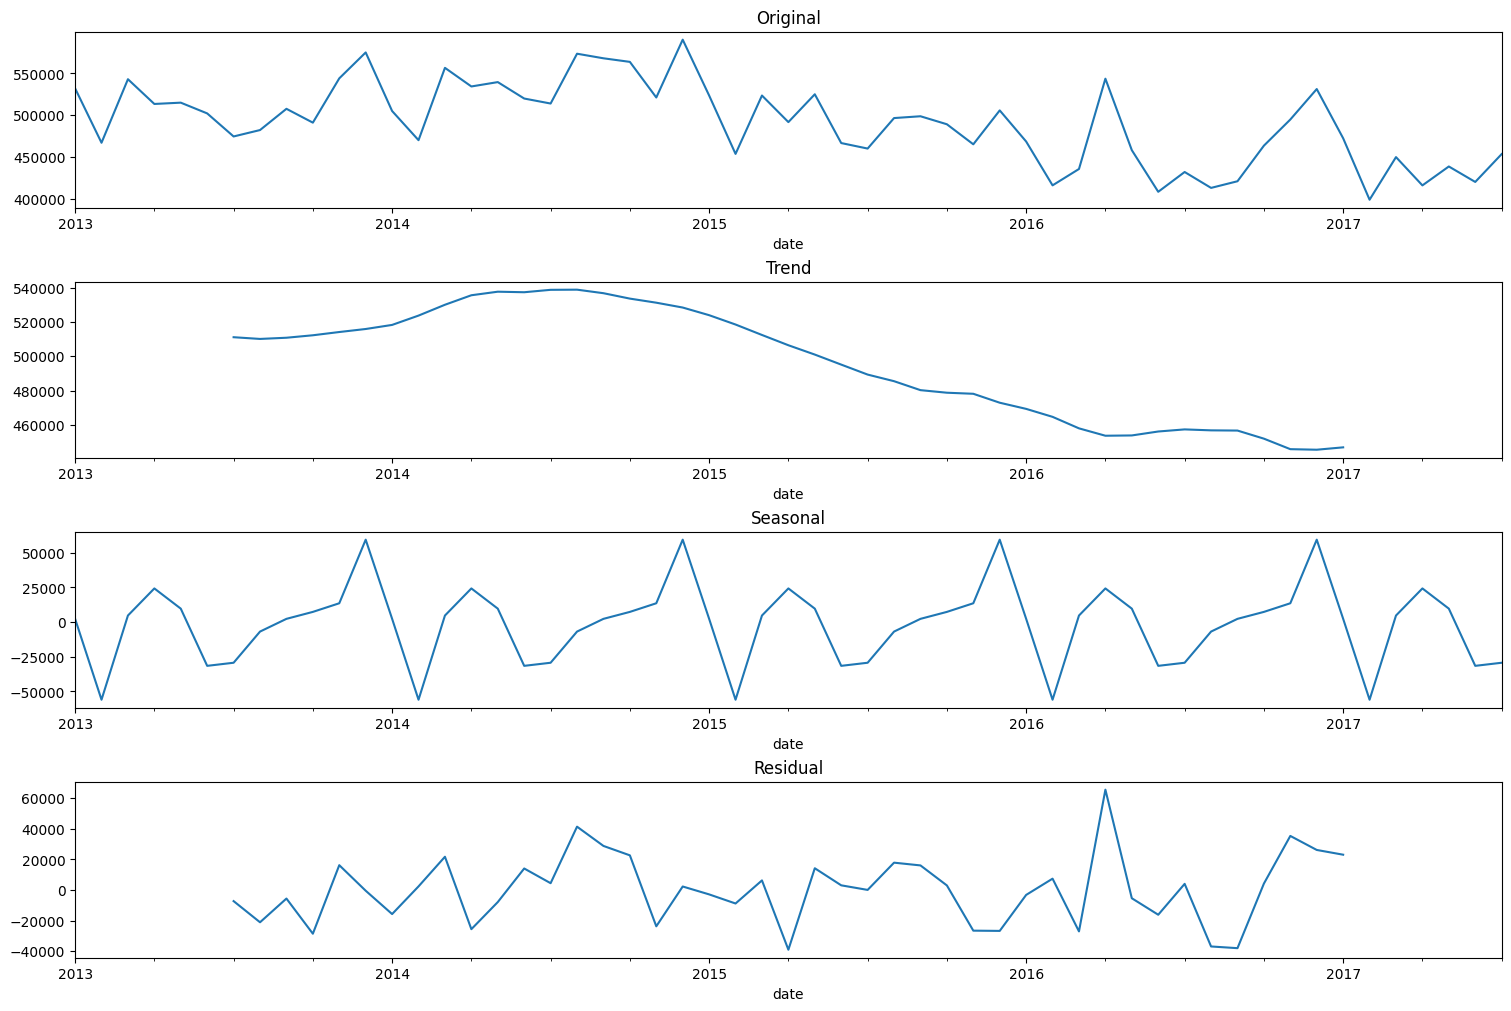

In [53]:
# série temporal da venda de todos os produtos
df_agg = df.groupby('date')['unit_sales'].sum().reset_index()

og_residual = decompose_series(df_agg['unit_sales'], period=12).resid
og_seasonal = decompose_series(df_agg['unit_sales'], period=12).seasonal
df_agg.set_index('date', inplace=True)
decompose_series(df_agg['unit_sales'], period=12, plot=True)

Estatística do teste ADF: -0.7873198611497035
Valor-p: 0.8228184161088707
A série temporal não é estacionária
Diferenciando a série temporal...

Estatística do teste ADF: -10.123993172453309
Valor-p: 9.284834317039425e-18
A série temporal é estacionária após a diferenciação


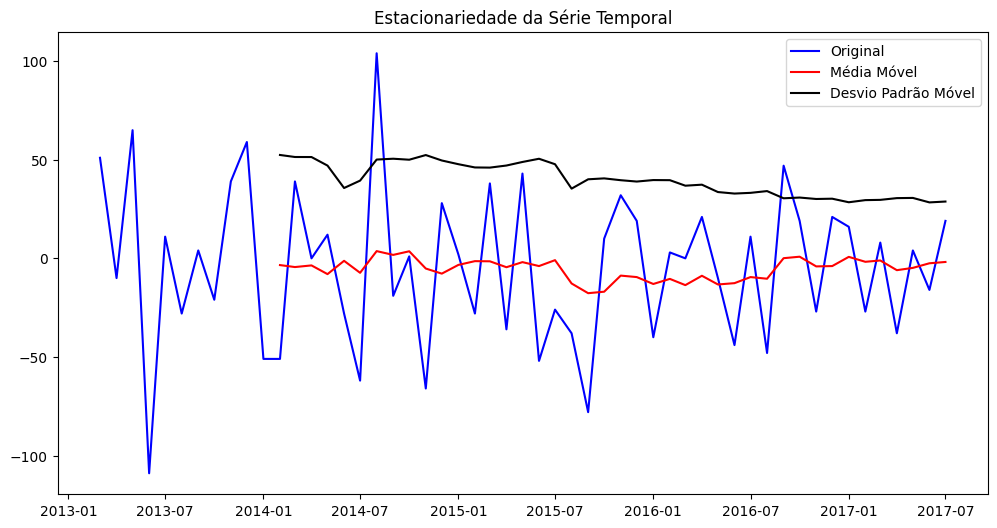

In [54]:
item_nbr = 870938 # produto classe: DAIRY, perishable: True
df_item = df[df['item_nbr'] == item_nbr]
#df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()
df_item.set_index('date', inplace=True)

# Executar o teste de Dickey-Fuller Aumentado
result = adfuller(df_item['unit_sales'].values)

# Resultados do teste
print('Estatística do teste ADF:', result[0])
print('Valor-p:', result[1])

# Interpretação do resultado
if result[1] <= 0.05:
    print("A série temporal é estacionária")
    data_diff = pd.Series(df_item['unit_sales'])
else:
    print("A série temporal não é estacionária")
    print("Diferenciando a série temporal...\n")
    data_diff = pd.Series(df_item['unit_sales']).diff().dropna()
    data_diff = data_diff.iloc[1:]
    result2 = adfuller(data_diff)
    print('Estatística do teste ADF:', result2[0])
    print('Valor-p:', result2[1])
    if result2[1] <= 0.05:
        print("A série temporal é estacionária após a diferenciação")
    else:
        print("A série temporal não é estacionária após a diferenciação")

# plottando
rolmean = data_diff.rolling(window=12).mean()
rolstd = data_diff.rolling(window=12).std()
plt.figure(figsize=(12, 6))
plt.plot(data_diff, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Média Móvel')
plt.plot(rolstd, color='black', label='Desvio Padrão Móvel')
plt.legend(loc='best')
plt.title('Estacionariedade da Série Temporal')
plt.show()

### Dados inteiros

<Axes: >

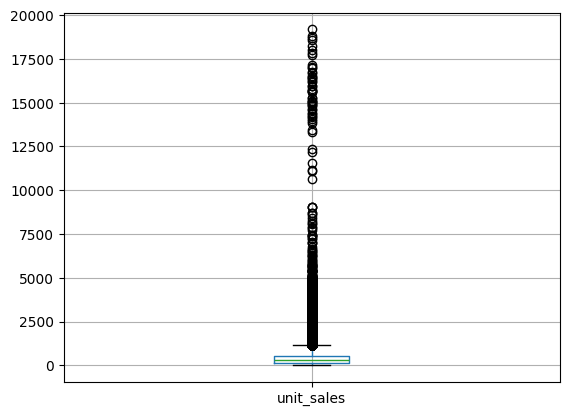

In [55]:
# boxplot to idenfity outliers
df.boxplot(column='unit_sales')

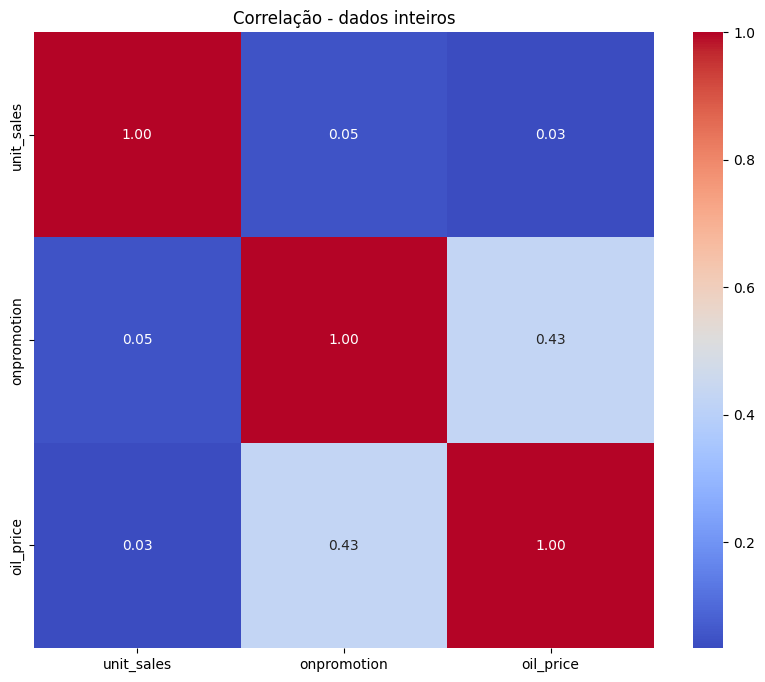

In [56]:
correlations = df[['unit_sales', 'onpromotion', 'oil_price']].corr()

# plotar a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação - dados inteiros')
plt.show()

### Vendas de uma família de produtos

In [57]:
df_family = df[df['family'] == 'DAIRY']

<Axes: >

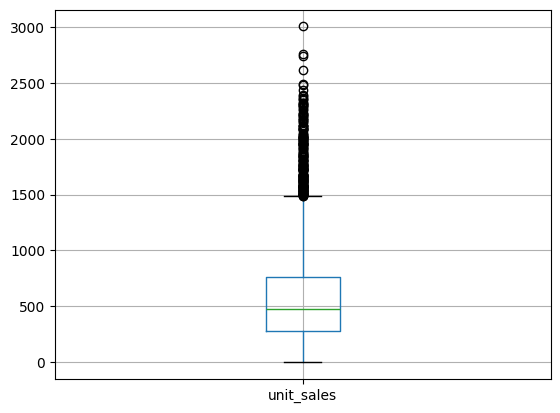

In [58]:
df_family.boxplot(column='unit_sales')

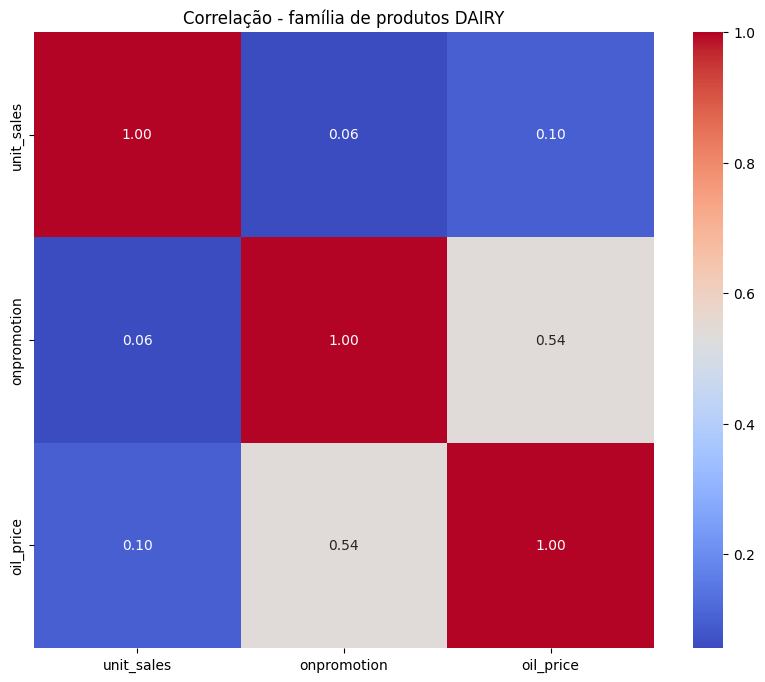

In [59]:
correlations = df_family[['unit_sales', 'onpromotion', 'oil_price']].corr()

# plotar a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação - família de produtos DAIRY')
plt.show()

### Vendas de um item

<Axes: >

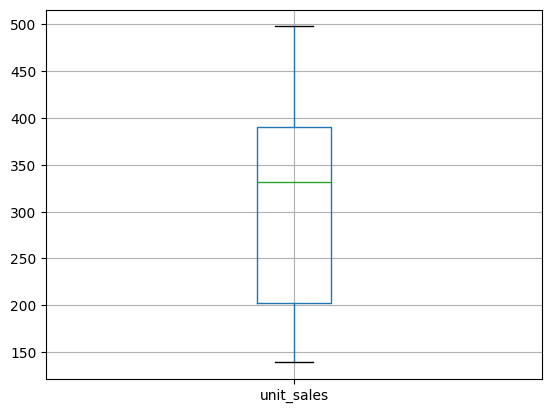

In [60]:
# boxplot to idenfity outliers
df_item.boxplot(column='unit_sales')

In [61]:
df_item.head(1)

,item_nbr,year,month,onpromotion,unit_sales,family,class,perishable,oil_price
date,,,,,,,,,
2013-01-01,870938,2013,1,True,436.00,DAIRY,2124,True,94.76


In [62]:
correlations = df_item[['unit_sales', 'onpromotion', 'oil_price']].corr()

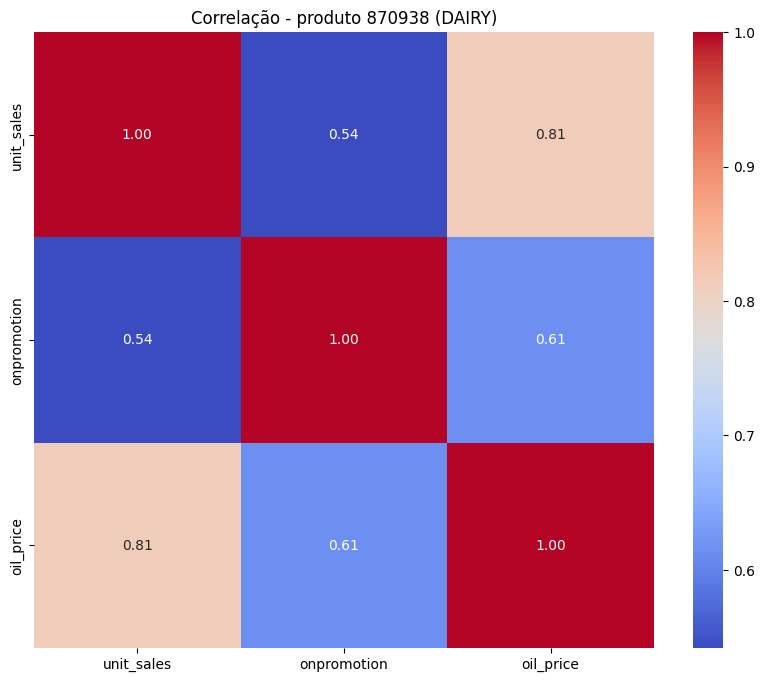

In [63]:
# plotar a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação - produto 870938 (DAIRY)')
plt.show()

# Testando a autocorrelação dos dados

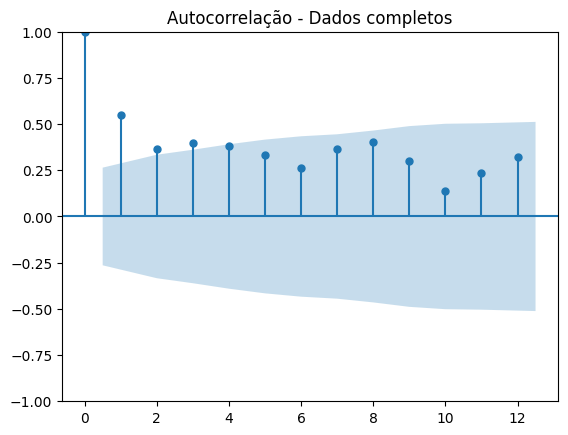

In [64]:
# Calcular a autocorrelação para as vendas dos dados agrupados

df_agg = df.groupby('date')['unit_sales'].sum().reset_index()

df_agg = df_agg.reset_index(drop=True)
df_agg = df_agg.set_index('date') # can cause problems

#acf_values = sm.tsa.acf(df_agg['unit_sales'].values, nlags=12)

# Plotar a função de autocorrelação
sm.graphics.tsa.plot_acf(df_agg['unit_sales'].values, lags=12)
plt.title("Autocorrelação - Dados completos")
plt.show()

## Teste de hipótese para o produto aleatório escolhido

| O teste de Ljung-Box é usado comumente usado na modelagem  
do modelo ARIMA. Feito para testar autocorrelação dos dados  
podemos passar vários lags para testar qual dará como resultado  
uma correlação, ou não.

In [65]:
# teste
df_item = df[df['item_nbr'] == 870938]

values = df_item['unit_sales'].values

lags = range(1, 13)
# Realiza o teste Ljung-Box
df_test = acorr_ljungbox(values, lags=lags)
stat, p_value = (df_test['lb_stat'], df_test['lb_pvalue'])

for lag, p_val in zip(lags, p_value):
    if p_val < 0.05:
        print(f'Autocorrelação significativa encontrada no lag {lag} com p-valor {p_val}')

Autocorrelação significativa encontrada no lag 1 com p-valor 1.2620914668522595e-11
Autocorrelação significativa encontrada no lag 2 com p-valor 1.2331001206487947e-19
Autocorrelação significativa encontrada no lag 3 com p-valor 2.419561342603751e-26
Autocorrelação significativa encontrada no lag 4 com p-valor 1.7001596289787725e-32
Autocorrelação significativa encontrada no lag 5 com p-valor 9.600329508291425e-38
Autocorrelação significativa encontrada no lag 6 com p-valor 3.3972383471224115e-42
Autocorrelação significativa encontrada no lag 7 com p-valor 1.872246330537621e-46
Autocorrelação significativa encontrada no lag 8 com p-valor 2.2384900133279036e-50
Autocorrelação significativa encontrada no lag 9 com p-valor 7.300225853364852e-54
Autocorrelação significativa encontrada no lag 10 com p-valor 8.5949269733627e-57
Autocorrelação significativa encontrada no lag 11 com p-valor 5.317612940727629e-59
Autocorrelação significativa encontrada no lag 12 com p-valor 2.884653508460305e-6

Valores da ACF para diferentes lags:
[1.         0.88890229 0.83464779 0.76475201 0.72926755 0.67375756
 0.62148419 0.60350161 0.57674655 0.54326819 0.50060657 0.44359681
 0.36115956]


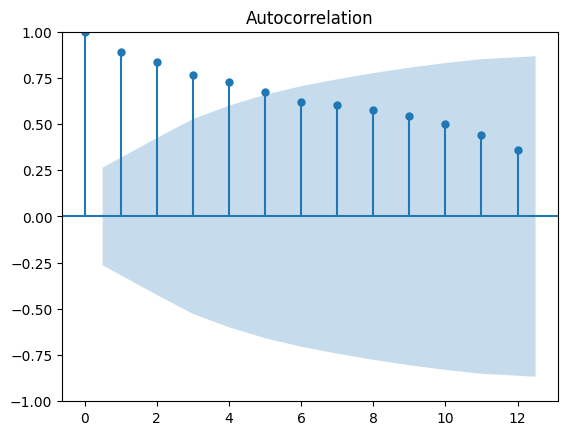

In [66]:
# Calcular a função de autocorrelação
acf_values = sm.tsa.acf(df_item['unit_sales'].values, nlags=12)
print("Valores da ACF para diferentes lags:")
print(acf_values)

# Plotar a função de autocorrelação
sm.graphics.tsa.plot_acf(df_item['unit_sales'].values, lags=12)
plt.show()

## Testando o restante dos itens do dataset

Valores da ACF para diferentes lags para o item 220435:
[1.         0.87278051 0.79536452 0.75939821 0.70958166 0.65851438
 0.64276433 0.6476683  0.60246131 0.56350888 0.47701088 0.38330732
 0.33597563]


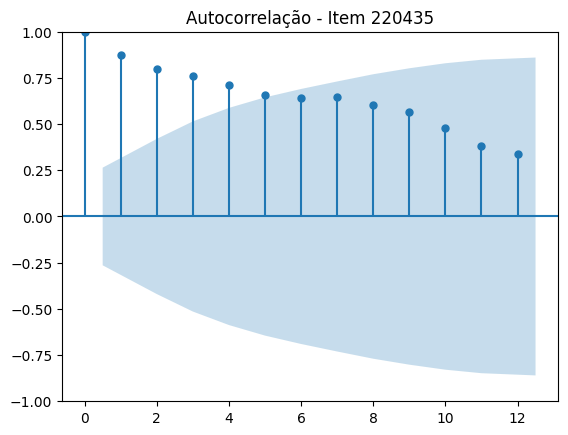

Valores da ACF para diferentes lags para o item 452212:
[1.         0.90353845 0.8704817  0.83009879 0.76578587 0.73083493
 0.69011977 0.61289434 0.56694454 0.50346221 0.43896704 0.36477419
 0.30212175]


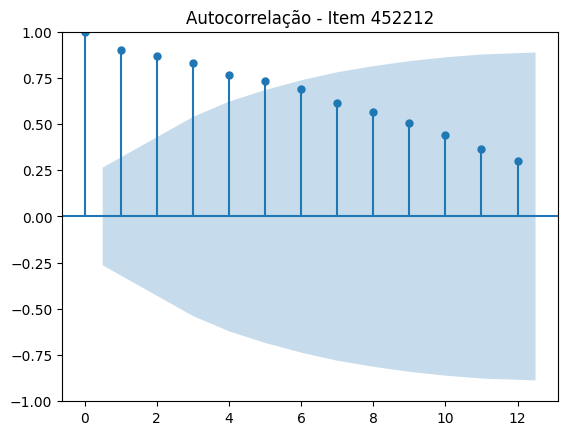

Valores da ACF para diferentes lags para o item 517905:
[1.         0.90258834 0.88759974 0.85006676 0.81146701 0.74455033
 0.70951844 0.62519457 0.6042444  0.53347622 0.46689611 0.39840773
 0.34965338]


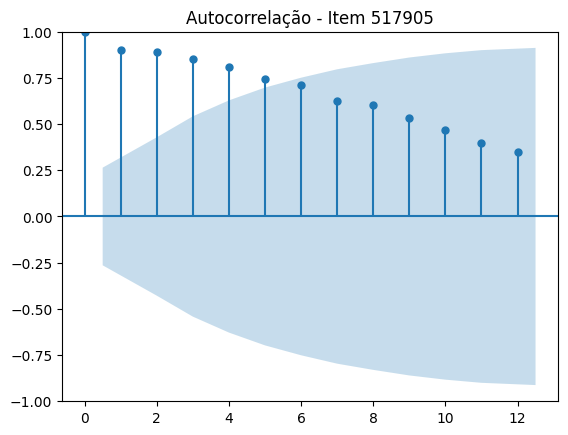

Valores da ACF para diferentes lags para o item 660502:
[1.         0.95554826 0.9102315  0.86603639 0.80715871 0.73424994
 0.66603089 0.60341356 0.52973694 0.45259345 0.37175326 0.29933964
 0.22204938]


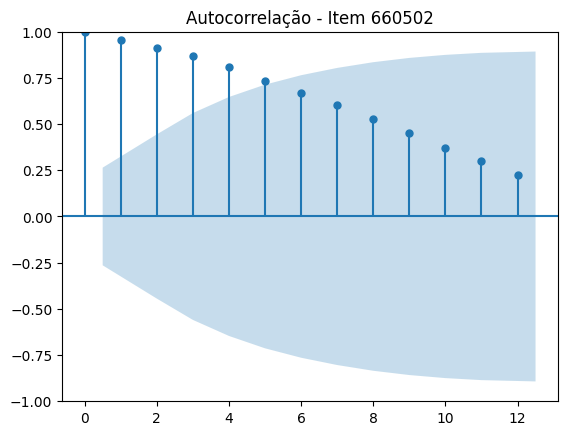

Valores da ACF para diferentes lags para o item 838409:
[1.         0.8751746  0.84299401 0.8080997  0.7711756  0.72371968
 0.6505412  0.61264082 0.54943824 0.4865049  0.43621456 0.37986427
 0.34354956]


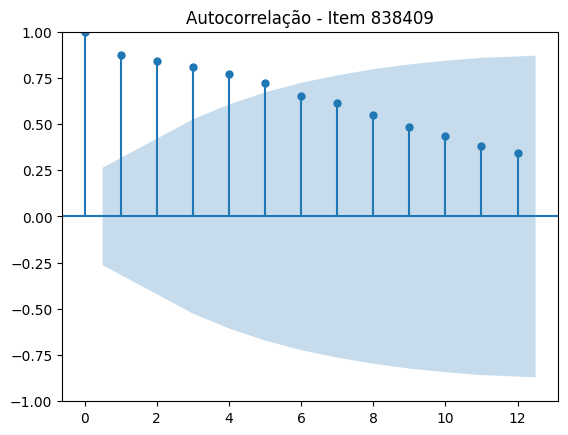

Valores da ACF para diferentes lags para o item 870938:
[1.         0.88890229 0.83464779 0.76475201 0.72926755 0.67375756
 0.62148419 0.60350161 0.57674655 0.54326819 0.50060657 0.44359681
 0.36115956]


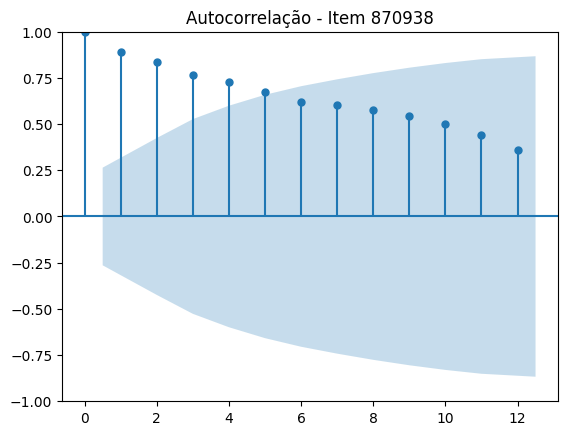

In [67]:
for item in df['item_nbr'].unique():
  df_item = df[df['item_nbr'] == item]
  df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()
  df_item.reset_index(drop=True, inplace=True)
  df_item.drop(columns='date', inplace=True)
  acf_values = sm.tsa.acf(df_item, nlags=12)
  acf_mean = acf_values.sum() / 12
  if acf_mean > 0.7:
    print(f"Valores da ACF para diferentes lags para o item {item}:")
    print(acf_values)
    sm.graphics.tsa.plot_acf(df_item, lags=12)
    plt.title(f"Autocorrelação - Item {item}")
    plt.show()

# Avaliando residuais

Pressupostos para previsão

*   Não devem estar autocorrelacionados
*   Média deve ser zero (aproximadamente)
*   Variância constante
*   Distribuição normal

In [68]:
item_nbr = 870938 # produto classe: DAIRY, perishable: True
df_item = df[df['item_nbr'] == item_nbr]

decomposition = seasonal_decompose(df_item['unit_sales'], period=12)
residuos_item = decomposition.resid
residuos_item.isna().sum() # preencher os valores nulos com a média dos valores não nulos                           # ou droppar

12

Devido aos valores nan, não consegui verificar a autocorrelação dos residuos. Será necessário tratar os dados de alguma forma (dropar ou trocar por outro valor).

In [69]:
residuos_item.dropna(inplace=True) # decidimos droppar

Valores da ACF para diferentes lags:
[ 1.          0.23417483 -0.05590812 -0.2673054  -0.26127031 -0.15885734
 -0.14925459 -0.00512965  0.20194912  0.4566488   0.15362928 -0.01753339
 -0.5127777 ]


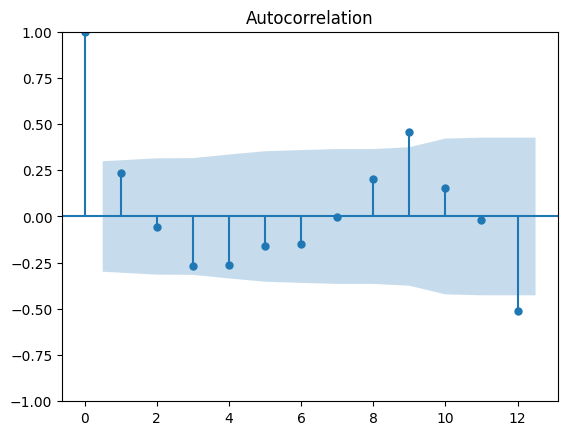

In [70]:
# Calcular a função de autocorrelação
acf_values = sm.tsa.acf(residuos_item.values, nlags=12)
print("Valores da ACF para diferentes lags:")
print(acf_values)

# Plotar a função de autocorrelação
sm.graphics.tsa.plot_acf(residuos_item.values, lags=12)
plt.show()

In [71]:
residuos_item.mean()

0.0888310185185383

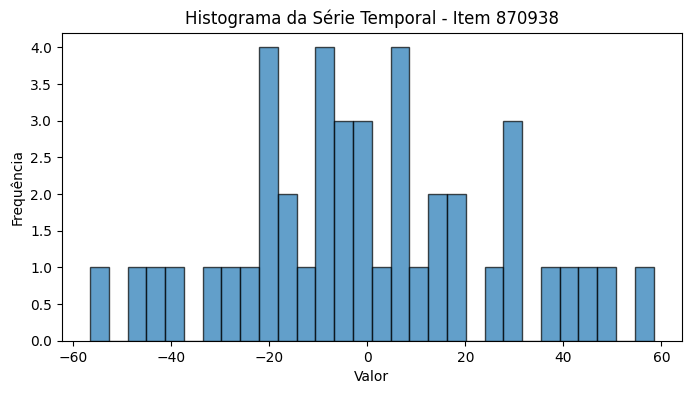

In [72]:
plt.figure(figsize=(8, 4))
plt.hist(residuos_item, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histograma da Série Temporal - Item ' + str(item_nbr))
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.show()

In [73]:
# Realizar o teste de Shapiro-Wilk
stat, p = shapiro(residuos_item)

# Exibir a estatística de teste e o valor p
print("Estatística de Teste:", stat)
print("Valor p:", p)

if p < 0.05:
  print("A distribuição não é normal (rejeita-se a hipótese nula).")
else:
  print("A distribuição é normal (aceita-se a hipótese nula).")

Estatística de Teste: 0.9901243828687453
Valor p: 0.969265560162455
A distribuição é normal (aceita-se a hipótese nula).


# Utilizando a biblioteca Lazypredict

In [74]:
# utilizando lazy prediction para escolher um modelo
X = df_agg.reset_index().index
y = df_agg['unit_sales']

X = pd.DataFrame(X, columns=['index']) # Convert X to a DataFrame

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

clear_output()
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RANSACRegressor,0.39,0.45,38825.55,0.01
AdaBoostRegressor,0.33,0.39,40709.12,0.05
HuberRegressor,0.30,0.37,41473.51,0.01
SGDRegressor,0.28,0.35,42249.24,0.00
TransformedTargetRegressor,0.27,0.35,42273.87,0.00
LinearRegression,0.27,0.35,42273.87,0.00
OrthogonalMatchingPursuit,0.27,0.35,42273.87,0.00
LassoLarsIC,0.27,0.35,42273.87,0.01
LassoLarsCV,0.27,0.35,42273.87,0.01


In [75]:
# utilizando lazy prediction para escolher um modelo
X = data_diff.reset_index().index
y = data_diff.values

# transform X to df
X = pd.DataFrame(X, columns=['index'])
X_df = pd.DataFrame(df_item.index, columns=['index'])

X_train = X.iloc[:-12]
X_test = X_df.iloc[-12:]

y_train = y[:-12]
y_test = df_item['unit_sales'].iloc[-12:]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

clear_output()
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,-57.71,-52.37,168.67,0.04
DecisionTreeRegressor,-57.71,-52.37,168.67,0.00
ExtraTreeRegressor,-57.71,-52.37,168.67,0.01
XGBRegressor,-57.75,-52.41,168.73,0.04
GradientBoostingRegressor,-59.96,-54.42,171.88,0.04
SVR,-65.37,-59.33,179.34,0.00
GaussianProcessRegressor,-65.54,-59.49,179.57,0.02
LinearSVR,-65.54,-59.49,179.57,0.00
BaggingRegressor,-67.09,-60.90,181.66,0.01


In [76]:
# Inicializar o LGBMRegressor
model = lgb.LGBMRegressor(
    n_estimators=100,       # Número de árvores
    learning_rate=0.1,      # Taxa de aprendizado
    max_depth=-1,           # Profundidade máxima das árvores (-1 significa sem limite)
    num_leaves=31,          # Número máximo de folhas em cada árvore
    random_state=42
)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
clear_output()
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 34052.583333333336


# Utilizando ARIMA

![chart.png](img/chart.png)

Percebe-se que a média móvel se ajusta bem aos dados.  
ARIMA nesse caso é uma boa opção como modelo.

In [77]:
def plot_forecast(train, test, forecast):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Treino')
    plt.plot(test, label='Teste')
    plt.plot(test.index, forecast, label='Previsão', color='red')
    plt.legend()

In [78]:
# Supondo que 'df_item' é o seu DataFrame e 'unit_sales' é a coluna que você quer prever
data = df_item['unit_sales'].reset_index(drop=True)

# Dividir os dados em treino e teste
train = data.iloc[:-12]
test = data.iloc[-12:]

train_diff = data_diff.reset_index(drop=True).iloc[:-12]
test_diff = data_diff.reset_index(drop=True).iloc[-12:]

xticks = df_item['date'].reset_index(drop=True)
# transform xticks dates to only year-month
xticks = xticks.apply(lambda x: x.strftime('%Y-%m'))

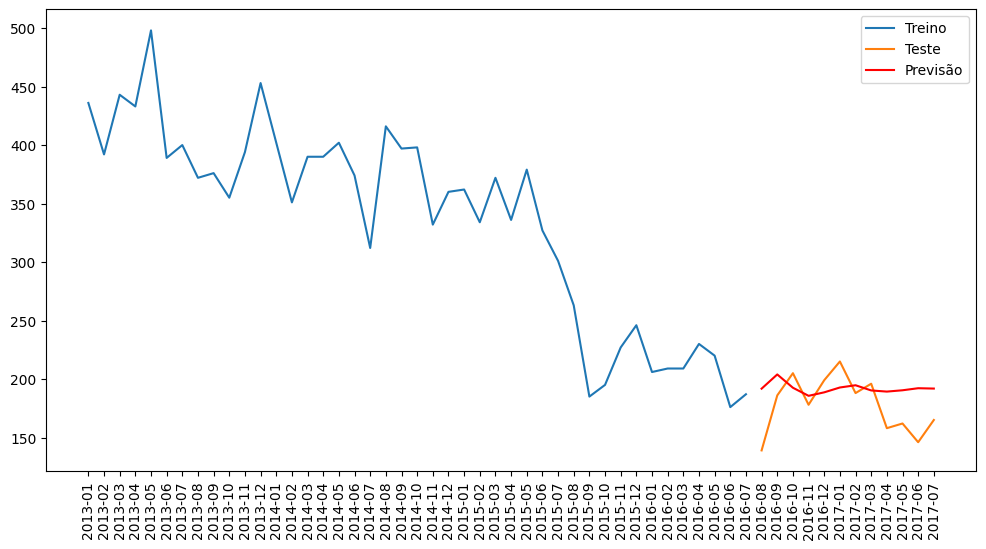

In [79]:
# Ajustar o modelo ARIMA
model = ARIMA(train, order=(5, 1, 0))  # (p, d, q) são os parâmetros do modelo ARIMA
model_fit = model.fit()
 
# Fazer previsões
forecast = model_fit.forecast(steps=12)
plot_forecast(train, test, forecast)
# xticks with datetime index
# change step to every 3 months
plt.xticks(range(len(df_item['unit_sales'])), xticks, rotation=90)
plt.show()

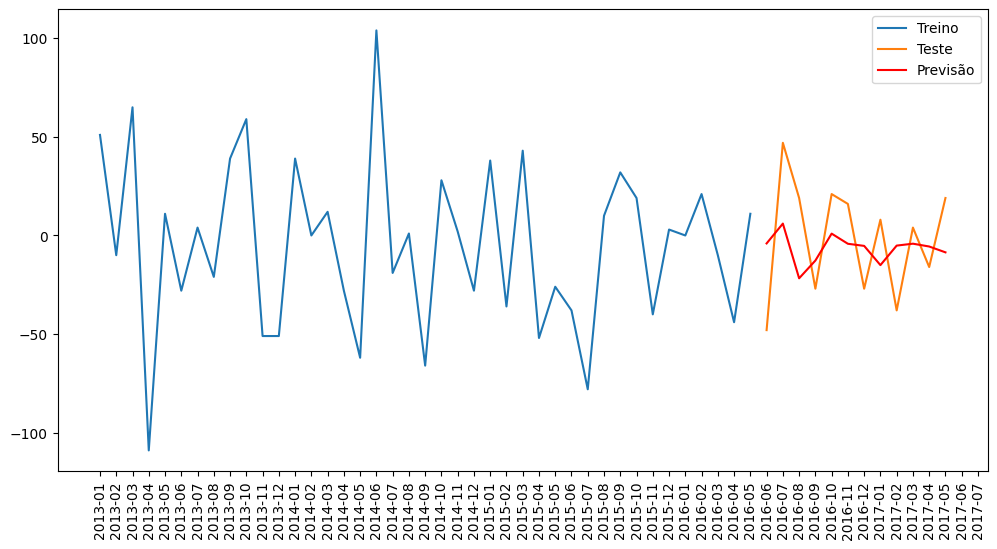

In [80]:
# Ajustar o modelo ARIMA
model = ARIMA(train_diff, order=(5, 1, 0))  # (p, d, q) são os parâmetros do modelo ARIMA
model_fit = model.fit()
 
# Fazer previsões
forecast = model_fit.forecast(steps=12)

# Plotar os resultados
plot_forecast(train_diff, test_diff, forecast)

# xticks with datetime index
# change step to every 3 months
plt.xticks(range(len(df_item['unit_sales'])), xticks, rotation=90)

plt.show()

## Utilizando SARIMAX

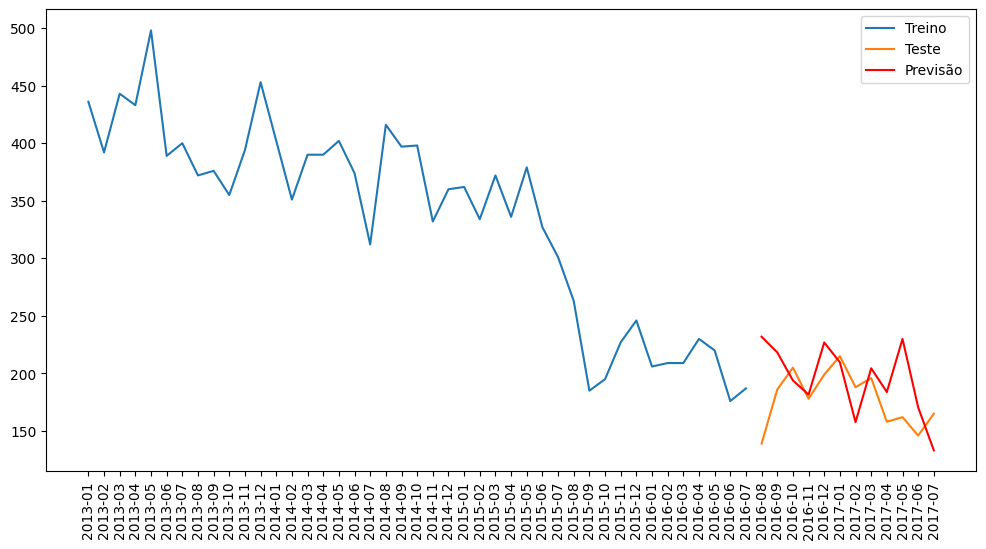

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

forecast = model_fit.forecast(steps=12)

plot_forecast(train, test, forecast)

# xticks with datetime index
# change step to every 3 months
plt.xticks(range(len(df_item['unit_sales'])), xticks, rotation=90)
plt.show()

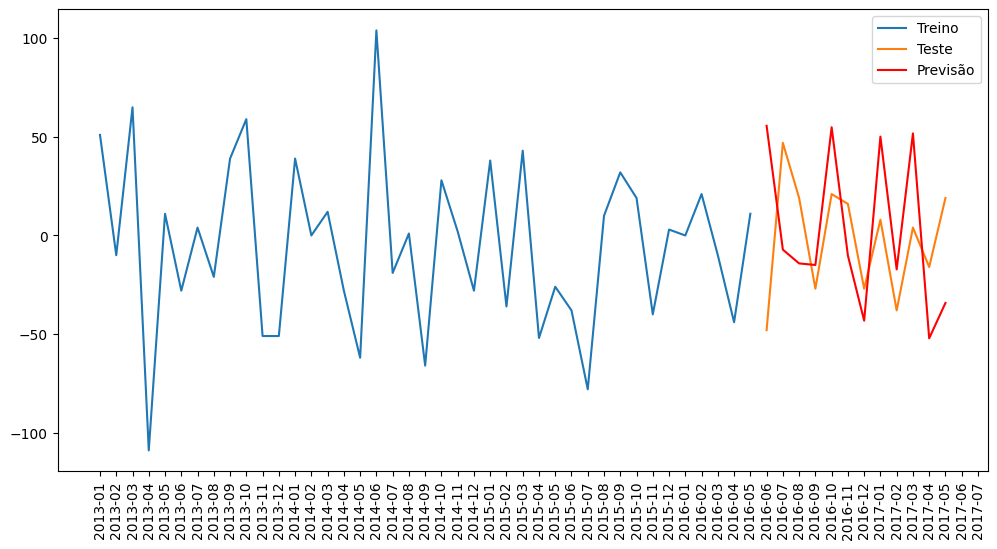

In [82]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_diff, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

forecast = model_fit.forecast(steps=12)

plot_forecast(train_diff, test_diff, forecast)

# xticks with datetime index
# change step to every 3 months
plt.xticks(range(len(df_item['unit_sales'])), xticks, rotation=90)
plt.show()

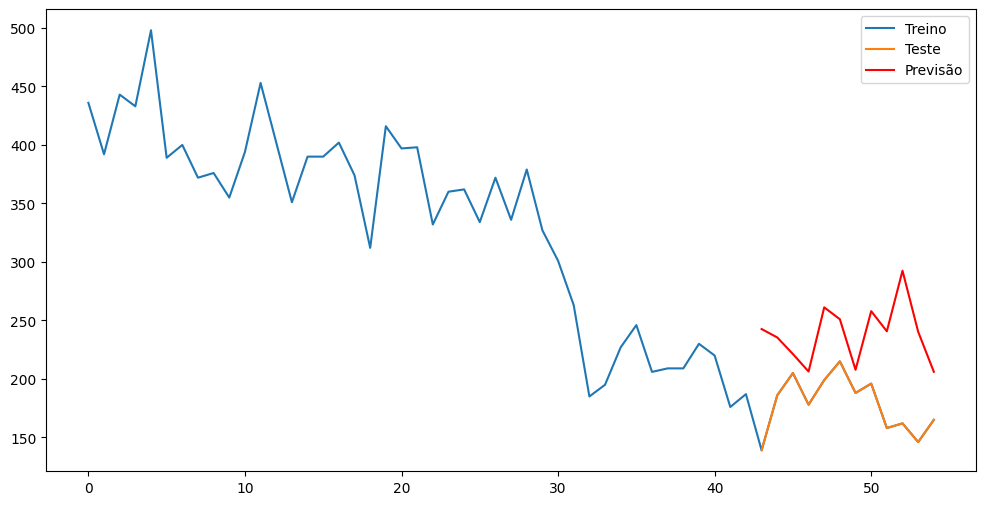

In [83]:
forecast_undiff = forecast.cumsum() + train.iloc[-1]

plot_forecast(data, test, forecast_undiff) # NOT WORKING 
                                           # ATS

In [84]:
train.iloc[-1]

187.0

análise de sensibilidade das variáveis, matriz de correlação
- preço do petróleo
- promoção

adicionar essas variáveis no modelo para ter uma previsão mais robusta
analisar também o tipo do produto, pois produtos que  
envolvem importação podem ter uma influência diretamente da economia

In [85]:
df['family'].unique()

array(['GROCERY I', 'BREAD/BAKERY', 'DELI', 'CLEANING', 'POULTRY',
       'PERSONAL CARE', 'AUTOMOTIVE', 'DAIRY', 'EGGS', 'BEVERAGES',
       'GROCERY II', 'MEATS', 'SEAFOOD', 'FROZEN FOODS', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'LAWN AND GARDEN'], dtype=object)

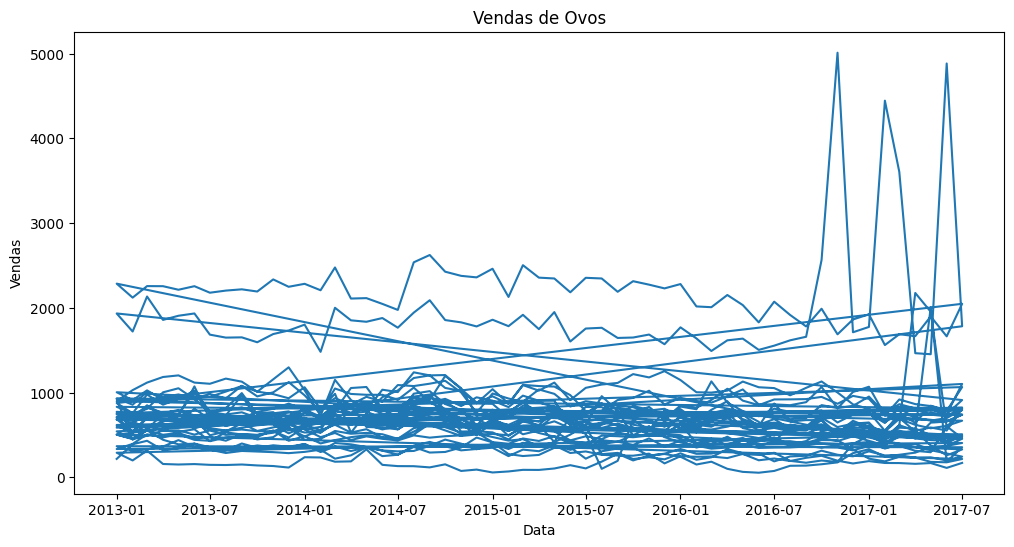

In [86]:
# ovos são produtos que vendem com facilidade e são perecíveis
egg_sales = df[df['family'] == 'EGGS']

# plotar a série temporal
plt.figure(figsize=(12, 6))
plt.plot(egg_sales['date'], egg_sales['unit_sales'])
plt.title('Vendas de Ovos')
plt.xlabel('Data')
plt.ylabel('Vendas')

plt.show()